In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime


c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [6]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
#ocean_discord['message_count'] = 1


In [9]:
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'])

# Group by 'Date' and aggregate counts of messages, attachments, and reactions
daily_activity = ocean_discord.groupby('Date').agg({
    'Content': 'count',       # Count of messages
}).reset_index()

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [11]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [12]:
def random_forest_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [13]:
# walk-forward validation for univariate data
from sklearn.metrics import mean_absolute_error 

def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [14]:
daily_activity['Date'] = pd.to_numeric(pd.to_datetime(daily_activity['Date']))
series = daily_activity[['Date', 'Content']]

values = series.values
data = series_to_supervised(values, n_in=6)

In [15]:
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

>expected=30.0, predicted=24.0
>expected=9.0, predicted=35.1
>expected=18.0, predicted=29.8
>expected=14.0, predicted=38.9
>expected=25.0, predicted=24.1
>expected=45.0, predicted=28.2
>expected=34.0, predicted=44.2
>expected=12.0, predicted=32.1
>expected=15.0, predicted=21.8
>expected=41.0, predicted=26.3
>expected=45.0, predicted=41.2
>expected=45.0, predicted=54.5
MAE: 12.632


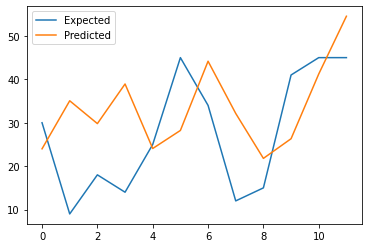

In [16]:
import matplotlib.pyplot as plt
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()